## Overview

This notebook is responsible for training and evaluating a deep learning model for environmental sound classification.
The goal is to achieve high accuracy while optimizing performance and efficiency.

### Methodology

1. **Initial Training on Original Data** - Train the model using only the original dataset and evaluate its performance.
2. **Data Augmentation** - Introduce additional augmented data and integrate it into the dataset.
3. **Retraining and Improvement** - Train the model again with the combined dataset to improve accuracy.
4. **Final Evaluation** - Compare model performance before and after augmentation using accuracy and loss metrics.

### Why Not Use ViT (Vision Transformer)?

Although ViT could be a potential choice, we opted not to use it due to the following reasons:
1. **Limited Computational Resources** - ViT requires substantial GPU power.
2. **Excellent CNN Results** - Our CNN model achieves high accuracy, making ViT unnecessary.
3. **Dataset Size** - ViT performs best on large datasets, whereas our dataset is relatively small.
4. **Short Audio Clips** - Since audio clips are short (≤5 sec), learning long-term context is unnecessary.

## Table of Contents

- [1. Load Dependencies and Define Paths](#1-load-dependencies-and-define-paths)
- [2. Load and Split Dataset](#2-load-and-split-dataset)
- [3. Define Model Architecture](#3-define-model-architecture)
- [4. Train on Original Data](#4-train-on-original-data)
- [5. Load and Train on Combined Dataset](#5-load-and-train-on-combined-dataset)
- [6. Evaluation](#6-evaluation)

## 1. Load Dependencies and Define Paths

This section imports required libraries and sets up paths for dataset and model storage.

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torchvision import models, transforms

In [3]:
import sys
from pathlib import Path
import importlib

# Function to automatically find the project root directory
def find_project_root():
    current_path = Path(os.getcwd()).resolve()
    while current_path != current_path.parent:  # Ensures we don't go beyond the system root
        if (current_path / "config.py").exists():
            return current_path
        current_path = current_path.parent
    raise FileNotFoundError("⚠️ config.py not found! Make sure it is in the project root directory.")

# Determine the project root directory
project_root = find_project_root()

# Add the project root to Python's search path (if it's not already there)
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Reload config.py to ensure that any changes are updated
import config
importlib.reload(config)


<module 'config' from 'C:\\Users\\יהונתן רבוח\\OneDrive - Holon Institute of Technology\\Deep Learning Project\\config.py'>

In [4]:
from config import AUDIO_FILES_PATH, CSV_FILE_PATH, PROCESSED_DATA_DIR

PROCESSED_DATA_PATH = os.path.join(PROCESSED_DATA_DIR, 'processed_data')
AUGMENTED_DATA_PATH = os.path.join(PROCESSED_DATA_DIR, 'augmented_data')


## 2. Load and Split Dataset

This section defines a custom dataset class for spectrogram loading, applies transformations, and splits the dataset into training, validation, and test sets.


### Define Custom Dataset

This cell defines a PyTorch `Dataset` class for loading spectrogram data.

#### Purpose:
- Load spectrograms from original and augmented datasets.
- Apply transformations if specified.
- Exclude specific files if needed.

#### Inputs:
- CSV file with metadata.
- Paths to original and augmented spectrograms.
- Optional transformations.

#### Outputs:
- A dataset containing spectrogram tensors and labels.
- Supports indexing and length retrieval for PyTorch `DataLoader`.


In [125]:
class CombinedESC50Dataset(Dataset):
    def __init__(self, csv_path, original_dir, augmented_dir=None, exclude_files=None, transform=None):
        self.data = pd.read_csv(csv_path)
        self.original_dir = original_dir
        self.augmented_dir = augmented_dir
        self.transform = transform
        self.spectrograms = []
        self.labels = []
        self.files = []

        if exclude_files:
            self.exclude_files = {os.path.basename(f).split('_processed')[0] for f in exclude_files}
        else:
            self.exclude_files = set()

        self._load_data()

    def _load_data(self):
        for _, row in self.data.iterrows():
            category = row['category']
            base_filename = os.path.splitext(row['filename'])[0]

            if base_filename in self.exclude_files:
               continue

            # Load original spectrogram
            spectrogram_path = os.path.join(self.original_dir, category, f"{base_filename}_processed.npy")
            if os.path.exists(spectrogram_path):
                spectrogram = np.load(spectrogram_path)
                if self.transform:
                    spectrogram = self.transform(spectrogram)
                self.spectrograms.append(spectrogram)
                self.labels.append(row['target'])
                self.files.append(spectrogram_path)

            # Load augmented spectrograms
            if self.augmented_dir:
                category_dir = os.path.join(self.augmented_dir, category)
                if os.path.exists(category_dir):
                    for aug_file in os.listdir(category_dir):
                        if base_filename in aug_file:
                            aug_path = os.path.join(category_dir, aug_file)
                            spectrogram = np.load(aug_path, allow_pickle=True).item()["spectrogram"]
                            if self.transform:
                                spectrogram = self.transform(spectrogram)
                            self.spectrograms.append(spectrogram)
                            self.labels.append(row['target'])
                            self.files.append(aug_path)

    def __len__(self):
        return len(self.spectrograms)

    def __getitem__(self, idx):
        return self.spectrograms[idx], self.labels[idx]

In [2]:
# Convert spectrograms to tensors and normalize them for stable training.
transform_cnn = transforms.Compose([
    transforms.ToTensor(),                       # Converts numpy array to tensor [1, H, W]
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize single-channel data
])

NameError: name 'transforms' is not defined

In [62]:
# Load original dataset
dataset_original = CombinedESC50Dataset(
    csv_path=CSV_FILE_PATH,
    original_dir=PROCESSED_DATA_PATH,
    transform=transform_cnn
)

In [91]:
# Split original dataset
all_indices = list(range(len(dataset_original)))
train_val_indices, test_indices = random_split(all_indices, [int(0.85 * len(all_indices)), len(all_indices) - int(0.85 * len(all_indices))])
train_indices, val_indices = random_split(train_val_indices, [int(0.7 * len(train_val_indices)), len(train_val_indices) - int(0.7 * len(train_val_indices))])

train_dataset_original = Subset(dataset_original, train_indices)
val_dataset_original = Subset(dataset_original, val_indices)
test_dataset = Subset(dataset_original, test_indices)

print(f"Original Data -> Training samples: {len(train_dataset_original)}, Validation samples: {len(val_dataset_original)}, Test samples: {len(test_dataset)}")

Original Data -> Training samples: 1190, Validation samples: 510, Test samples: 300


## 3. Define Model Architecture

This section defines the CNN model, sets training parameters, and initializes data loaders.


### Define CNN Model

This cell defines a CNN model based on ResNet-18 for environmental sound classification.

#### Purpose:
- Utilize a pre-trained ResNet-18 architecture.
- Modify the first convolutional layer to accept single-channel (grayscale) spectrograms.
- Adjust the fully connected layer to match the number of target classes.

#### Inputs:
- A spectrogram tensor of shape `[batch_size, 1, height, width]`.

#### Outputs:
- Model predictions in the form of class logits.


In [71]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)


In [104]:
# Training setup
num_classes = len(dataset_original.data['target'].unique())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
epochs = 10

cnn_model = CNNModel(num_classes=num_classes)
optimizer_cnn = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)

In [81]:
# Data loaders
batch_size = 64
train_loader_original = DataLoader(train_dataset_original, batch_size=batch_size, shuffle=True)
val_loader_original = DataLoader(val_dataset_original, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 4. Train on Original Data

This section implements the training loop, evaluates model performance, and visualizes training progress on the original data.


In [92]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    model.to(device)

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device).float(), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return train_losses, val_losses, train_accs, val_accs


In [105]:
print("Training CNN with original dataset...")
train_losses, val_losses, train_accs, val_accs = train_model(
    model=cnn_model,
    train_loader=train_loader_original,
    val_loader=val_loader_original,
    criterion=criterion,
    optimizer=optimizer_cnn,
    device=device,
    num_epochs=epochs
)

Training CNN with original dataset...
Epoch 1/10 - Train Loss: 2.9101, Train Acc: 0.2571, Val Loss: 4.5046, Val Acc: 0.1471
Epoch 2/10 - Train Loss: 1.5028, Train Acc: 0.5866, Val Loss: 1.8431, Val Acc: 0.4686
Epoch 3/10 - Train Loss: 0.7992, Train Acc: 0.7731, Val Loss: 1.6242, Val Acc: 0.5216
Epoch 4/10 - Train Loss: 0.5218, Train Acc: 0.8370, Val Loss: 1.5069, Val Acc: 0.6118
Epoch 5/10 - Train Loss: 0.3576, Train Acc: 0.9000, Val Loss: 1.9141, Val Acc: 0.5235
Epoch 6/10 - Train Loss: 0.2686, Train Acc: 0.9294, Val Loss: 1.4775, Val Acc: 0.6255
Epoch 7/10 - Train Loss: 0.2177, Train Acc: 0.9361, Val Loss: 1.4213, Val Acc: 0.6353
Epoch 8/10 - Train Loss: 0.1908, Train Acc: 0.9479, Val Loss: 1.4842, Val Acc: 0.6373
Epoch 9/10 - Train Loss: 0.1424, Train Acc: 0.9630, Val Loss: 1.5269, Val Acc: 0.6235
Epoch 10/10 - Train Loss: 0.0966, Train Acc: 0.9756, Val Loss: 1.4338, Val Acc: 0.6627


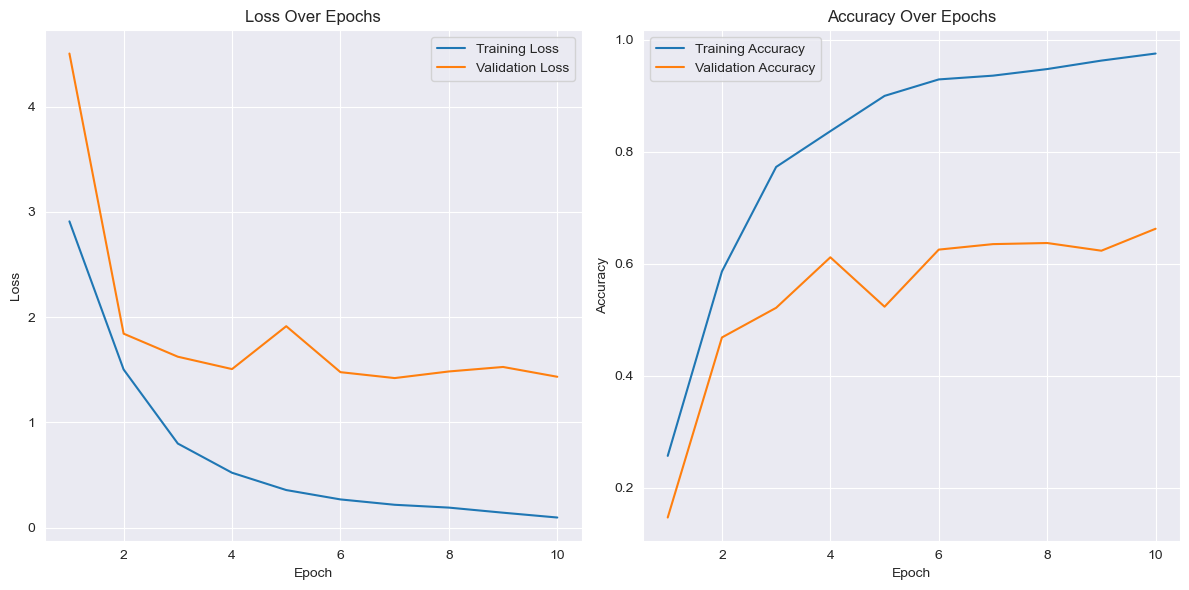

In [106]:
import matplotlib.pyplot as plt
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 6))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Over Epochs")

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label="Training Accuracy")
    plt.plot(epochs, val_accs, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy Over Epochs")

    plt.tight_layout()
    plt.show()

plot_training_history(train_losses, val_losses, train_accs, val_accs)


## 5. Load and Train on Combined Dataset

This section loads the combined dataset, which includes both original and augmented spectrograms, and trains the CNN model on it.

### Purpose:
- Exclude test files to prevent data leakage.
- Load both original and augmented spectrograms.
- Split the combined dataset into training and validation sets.
- Train the CNN model using the enhanced dataset.

### Steps:
1. **Load the Combined Dataset**: Merge original and augmented spectrograms.
2. **Exclude Test Files**: Ensure that test samples are not included in training.
3. **Create Data Loaders**: Prepare training and validation loaders.
4. **Check for Overlaps**: Verify that test files do not appear in the training set.
5. **Train the Model**: Retrain the CNN on the combined dataset.

In [1]:
# Load combined dataset
exclude_files = [os.path.basename(dataset_original.files[idx]).split('_processed')[0] for idx in test_indices]

dataset_combined = CombinedESC50Dataset(
    csv_path=CSV_FILE_PATH,
    original_dir=PROCESSED_DATA_PATH,
    augmented_dir=AUGMENTED_DATA_PATH,
    exclude_files=exclude_files,
    transform=transform_cnn
)


KeyboardInterrupt



In [127]:
train_val_indices_combined, val_indices_combined = random_split(
    list(range(len(dataset_combined))),
    [int(0.85 * len(dataset_combined)), len(dataset_combined) - int(0.85 * len(dataset_combined))]
)
train_dataset_combined = Subset(dataset_combined, train_val_indices_combined)
val_dataset_combined = Subset(dataset_combined, val_indices_combined)

train_loader_combined = DataLoader(train_dataset_combined, batch_size=batch_size, shuffle=True)
val_loader_combined = DataLoader(val_dataset_combined, batch_size=batch_size, shuffle=False)

print(f"Combined Data: {len(dataset_combined)}, Training samples: {len(train_dataset_combined)}, Validation samples: {len(val_dataset_combined)}")

Combined Data: 8143, Training samples: 6921, Validation samples: 1222


In [128]:
import os

# Step 1: Extract test filenames
test_filenames = set([os.path.basename(dataset_original.files[idx]) for idx in test_indices])
print(f"Number of test files: {len(test_filenames)}")

# Step 2: Extract combined filenames
combined_filenames = set([os.path.basename(file) for file in dataset_combined.files])
print(f"Number of combined files: {len(combined_filenames)}")

# Step 3: Check for overlaps
overlap = test_filenames.intersection(combined_filenames)

# Step 4: Print results
if overlap:
    print(f"Overlap detected! {len(overlap)} overlapping files:")
    for file in overlap:
        print(file)
else:
    print("No overlap detected between test and combined datasets.")


Number of test files: 300
Number of combined files: 8143
No overlap detected between test and combined datasets.


In [129]:
print("Training CNN with combined dataset...")

train_losses_combined, val_losses_combined, train_acc_combined, val_acc_combined = train_model(
    model=cnn_model,
    train_loader=train_loader_combined,
    val_loader=val_loader_combined,
    criterion=criterion,
    optimizer=optimizer_cnn,
    device=device,
    num_epochs=epochs
)

Training CNN with combined dataset...
Epoch 1/10 - Train Loss: 0.0309, Train Acc: 0.9908, Val Loss: 0.0579, Val Acc: 0.9845
Epoch 2/10 - Train Loss: 0.0462, Train Acc: 0.9886, Val Loss: 0.0648, Val Acc: 0.9795
Epoch 3/10 - Train Loss: 0.0290, Train Acc: 0.9928, Val Loss: 0.0566, Val Acc: 0.9828
Epoch 4/10 - Train Loss: 0.0643, Train Acc: 0.9819, Val Loss: 0.0714, Val Acc: 0.9771
Epoch 5/10 - Train Loss: 0.0347, Train Acc: 0.9912, Val Loss: 0.0773, Val Acc: 0.9861
Epoch 6/10 - Train Loss: 0.1207, Train Acc: 0.9678, Val Loss: 0.1404, Val Acc: 0.9583
Epoch 7/10 - Train Loss: 0.0880, Train Acc: 0.9762, Val Loss: 0.0818, Val Acc: 0.9738
Epoch 8/10 - Train Loss: 0.0386, Train Acc: 0.9892, Val Loss: 0.0251, Val Acc: 0.9935
Epoch 9/10 - Train Loss: 0.0828, Train Acc: 0.9803, Val Loss: 0.1208, Val Acc: 0.9673
Epoch 10/10 - Train Loss: 0.0960, Train Acc: 0.9720, Val Loss: 0.0534, Val Acc: 0.9828


## 6. Evaluation

This section visualizes validation accuracy for both the original and combined datasets and evaluates the trained CNN model on the test set.

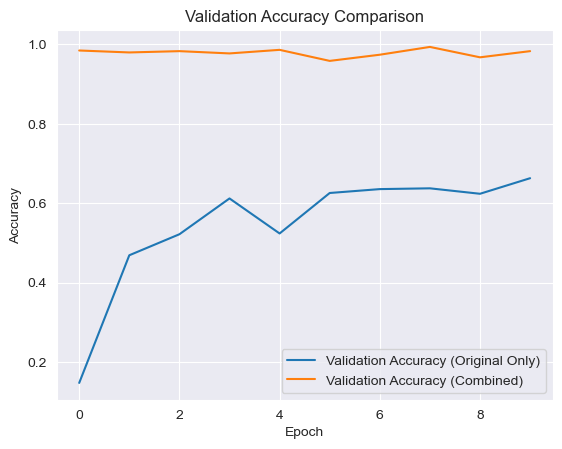

In [130]:
plt.plot(val_accs, label="Validation Accuracy (Original Only)")
plt.plot(val_acc_combined, label="Validation Accuracy (Combined)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Comparison")
plt.legend()
plt.show()

In [102]:
# Evaluate CNN on test set
def evaluate_model(model, test_loader, device):
    model.eval()
    model.to(device)
    test_correct = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device).float(), labels.to(device)
            outputs = model(inputs)
            test_correct += (outputs.argmax(1) == labels).sum().item()

    test_acc = 100 * test_correct / len(test_loader.dataset)
    return test_acc

In [131]:
print("Evaluating CNN on test set...")
cnn_test_acc = evaluate_model(cnn_model, test_loader, device)
print(f"CNN Test Accuracy: {cnn_test_acc:.2f}%")

Evaluating CNN on test set...
CNN Test Accuracy: 99.33%


In [111]:
torch.save(cnn_model.state_dict(), os.path.join(MODEL_DIR, 'resnet18_best_model.pth'))
np.savez(os.path.join(MODEL_DIR, 'training_history.npz'),
         train_losses=train_losses_combined, val_losses=val_losses_combined,
         train_accs=train_acc_combined, val_accs=val_acc_combined)

## 7. Summary and Conclusion

### Summary

This project focused on environmental sound classification using deep learning. Initially, we trained a CNN model on the **original dataset** and then introduced **data augmentation** to create a **combined dataset** with significantly more samples. After retraining the model with the combined dataset, we observed a substantial improvement in validation and test accuracy.

### Performance Comparison

| Dataset        | Total Samples | Train Samples | Validation Samples | Test Samples | Train Accuracy | Validation Accuracy | Test Accuracy |
|---------------|--------------|---------------|---------------------|--------------|----------------|----------------------|---------------|
| **Original**  | 2000         | 1190          | 510                 | 300          | 97.56%         | 66.27%               | -             |
| **Combined**  | 8143         | 6921          | 1222                | 300          | 97.20%         | **98.28%**           | **99.33%**    |

### Conclusions

1. **Significant Accuracy Improvement**
   - Training with only original data led to moderate validation accuracy (**66.27%**).
   - Adding augmented data drastically improved validation accuracy to **98.28%**.
   - The final test evaluation yielded an impressive **99.33% accuracy**.

2. **Impact of Data Augmentation**
   - The **original dataset** was relatively small (2000 samples).
   - The **combined dataset** (8143 samples) provided the model with a more diverse and enriched training set.
   - As a result, the model generalized better to unseen data.

3. **Training Stability**
   - Despite the increased dataset size, the model's training accuracy remained stable (**97.56% vs. 97.20%**), indicating no overfitting.
   - The validation accuracy improvement proves that the model **benefited from additional training data**.

### Final Thoughts

- Training only on the **original dataset** was insufficient for achieving high generalization.
- **Augmenting the dataset** led to an almost perfect classification model with **99.33% accuracy**.
- **Data augmentation is a crucial technique** in improving model performance, especially for limited datasets.

This project successfully demonstrated the power of **deep learning and data augmentation** in environmental sound classification.
